 Generative Adversarial Network (GAN)






## Part 1. Importing libraries and downloading the dataset and pre-trained weights
**Please do NOT modify any of the code in this part!**

In [ ]:
import argparse
import os
import random

import torch
import torch.nn as nn

import torchvision
import torchvision.transforms as transforms
import torchvision.utils as utils

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import time

try:
    torch.use_deterministic_algorithms(True)
    torch.backends.cudnn.deterministic = True
except:
    pass

The following code will switch to CUDA device automatically to accelerate your code if GPU is available in your computing environment.

To enable GPU in Google Colab:
1. Navigate to `Edit → Notebook Settings → Hardware Accelerator` or alternatively to `Runtime → Change runtime type → Hardware Accelerator`
2. Select `T4 GPU`.

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# If you encounter issues with CUDA device, e.g., "RuntimeError: CUDA Out of memory error",
# try to switch the device to CPU by using the following commented code:

# device = torch.device('cpu')

print('Device:', device)

Device: cpu


Finally, we use the [onedrivedownloader](https://pypi.org/project/onedrivedownloader/) package for downloading the data and pre-trained weights.

In [ ]:
!pip install onedrivedownloader

In [ ]:
from onedrivedownloader import download

link1 = 'https://unioulu-my.sharepoint.com/:u:/g/personal/jukmaatt_univ_yo_oulu_fi/EXSonItiHilPoo2WequIRCIBr-RdQDTH2xWvmpjbdGisxQ?e=4QbKCv'

link2 = 'https://unioulu-my.sharepoint.com/:u:/g/personal/jukmaatt_univ_yo_oulu_fi/EUvPUbTJW4NNiyc5Nmdf_C0ByyC6eAPf7BdRW_lQE-WDQw?e=lTrBx0'

if not os.path.exists('./data_hw4/anime'):
    print('Downloading the AnimeFace dataset')
    download(link1, filename='./anime.zip', unzip=True, unzip_path='./data_hw4/anime')

if not os.path.exists('./pretrained'):
    print('Downloading pre-trained weights')
    download(link2, filename='./gan_pretrained.zip', unzip=True, unzip_path='./pretrained')

100%|██████████| 21.5M/21.5M [00:01<00:00, 16.6MiB/s]


Unzipping file...


Extracting files: 100%|██████████| 2000/2000 [00:00<00:00, 5769.97it/s]


100%|██████████| 2.01M/2.01M [00:00<00:00, 3.05MiB/s]


Unzipping file...


Extracting files: 100%|██████████| 2/2 [00:00<00:00, 80.45it/s]


## Part 2. Build your own GAN

**Some of the following content and figures have been taken from this [course](https://developers.google.com/machine-learning/gan). You are encouraged to check the site for more details on GANs.**

A [**Generative Adversarial Network (GAN)**](https://en.wikipedia.org/wiki/Generative_adversarial_network) consists of two parts:

* The **generator** learns to generate plausible data. The generated instances become negative training examples for the discriminator.

* The **discriminator** learns to distinguish real samples from the fake data created by the generator. The discriminator penalizes the generator for not being able to produce credible outputs.

At the beginning of the training process, the generator produces evidently fake samples, thus the discriminator learns quickly to tell that they are fake. As training progresses, the generator starts to become capable of producing outputs that may fool the discriminator.

<img src="https://developers.google.com/static/machine-learning/gan/images/bad_gan.svg" width="650" style="float: left;">


<img src="https://developers.google.com/static/machine-learning/gan/images/ok_gan.svg" width="650" style="float: left;">

Finally, if the training of the generator goes well, the discriminator gets worse at differentiating the fake samples from real ones. Thus, the discriminator begins to classify fake samples as real, and, consequently, its accuracy starts decreasing.

<img src="https://developers.google.com/static/machine-learning/gan/images/good_gan.svg" width="650" style="float: left;">

The whole framework of a GAN can be illustrated as follows:

<img src="https://developers.google.com/static/machine-learning/gan/images/gan_diagram.svg" width="650" style="float: left;">

In the following parts, we will build a simple generator and discriminator based on [DCGAN (Deep Convolutional Generative Adversarial Network)](https://arxiv.org/abs/1511.06434) by Radford et al.

GANs have been known to be unstable to train, often resulting in generators that produce nonsensical outputs. To achieve stable deep convolutional GANs, Radford et al. proposed the following main architecture guidelines and common changes to typical convolutional neural networks (CNNs):
* Replace any pooling layers with strided convolutions in discriminator and fractional-strided convolutions (also known as deconvolution or transposed convolutions) in generator.
* Remove fully connected hidden layers for deeper architectures.
* Use ReLU activation in generator for all layers except for the output, which uses Tanh, as using a bounded activation allows the model to learn more quickly to saturate and cover the color space of the training distribution.
* Use LeakyReLU activation in the discriminator for all layers.
* Use batch normalization in both the generator and the discriminator, except for the generator output layer and the discriminator input layer, which may result in sample oscillation and model instability.

For more details, please refer to the original paper linked above.

Please note, however, that DCGAN is already an old method, published approximately ten years ago, thus there are better architectural choices for implementing GANs. We have selected DCGAN for this hands-on tutorial so that you can more easily gain understanding on the basics how GANs work.

### 2.1 Build the generator (<span style="color:green">2 points</span>)

The generator takes a batch of random noise vectors as input and generates an image for each noise vector.
- The batch of random noise vectors has a shape of `(B, 100)`, where `B` is the batch size and `100` is the length of a single noise vector. We convert the shape to `(B, 100, 1, 1)`, i.e., `(batch_size, channels, height, width)`, to make the input batch suitable for convolutional operations.
- As shown in the figure below, our generator consists of four convolutional layers, expanding the resolution of the feature maps layer by layer and finally obtaining the generated images as outputs with the shape of `(B, 3, 32, 32)`, i.e., `B` three-channel (RGB) images with resolution of 32 × 32 pixels.

Let's build the generator based on the architecture illustrated in the following figure.

<img src="http://yty.kapsi.fi/DLcourse/ass4/Generator.png" width="600" style="float: left;">

**Hints:**
1. The Generator class is inherited from [**`nn.Module`**](https://pytorch.org/docs/stable/generated/torch.nn.Module.html), thus we need to define the model layers in **`__init__()`** and implement the forward pass in **`forward()`**.


2. We use some built-in PyTorch classes, so try to check their documentation carefully if you encounter issues when using them.
- `ConvTransposed` denotes [**`nn.ConvTranspose2d()`**](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html), for which we need to assign the parameters: `in_channels`, `out_channels`, `kernel_size`, `stride`, and `padding`, and use **`bias=False`** in our implementation. Please check the figure carefully to choose the correct parameter values for each layer.

- `BN` denotes [**`nn.BatchNorm2d()`**](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html), for which we need to assign the correct value for the parameter `num_features`.

- `ReLU` denotes [**`nn.ReLU()`**](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html) and `Tanh` denotes [**`nn.Tanh()`**](https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html) that do not need any parameters.

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()

        # conv1: (B, 100, 1, 1) -> (B, 128, 4, 4)
        self.conv1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=100, out_channels=128, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(True)
        )

        # conv2: (B, 128, 4, 4) -> (B, 64, 8, 8)
        self.conv2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(True)
        )

        # conv3: (B, 64, 8, 8) -> (B, 32, 16, 16)
        self.conv3 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(True)
        )

        # conv4: (B, 32, 16, 16) -> (B, 3, 32, 32)
        self.conv4 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=32, out_channels=3, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        return x

Check whether your implementation matches the reference.

In [ ]:
# Create the generator
model_G = Generator().to(device)
print(model_G, '\n')

B = 2
noises = torch.randn((B, 100, 1, 1), device=device)
images = model_G(noises) # It will call the `forward()` function when using `model_G()`.

print('Shape of input:', noises.shape)
print('Shape of output:', images.shape)

Generator(
  (conv1): Sequential(
    (0): ConvTranspose2d(100, 128, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv3): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv4): Sequential(
    (0): ConvTranspose2d(32, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): Tanh()
  )
) 

Shape of input: torch.Size([2, 100, 1, 1])
Shape of output: torch.Size([2, 3, 32, 32])


**<span style="color:green">Reference implementation:</span>** <br>
Generator(<br>
&emsp;(conv1): Sequential(<br>
&emsp;&emsp;(0): ConvTranspose2d(100, 128, kernel_size=(4, 4), stride=(1, 1), bias=False)<br>
&emsp;&emsp;(1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)<br>
&emsp;&emsp;(2): ReLU()<br>
&emsp;)<br>
&emsp;(conv2): Sequential(<br>
&emsp;&emsp;(0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)<br>
&emsp;&emsp;(1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)<br>
&emsp;&emsp;(2): ReLU()<br>
&emsp;)<br>
&emsp;(conv3): Sequential(<br>
&emsp;&emsp;(0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)<br>
&emsp;&emsp;(1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)<br>
&emsp;&emsp;(2): ReLU()<br>
&emsp;)<br>
&emsp;(conv4): Sequential(<br>
&emsp;&emsp;(0): ConvTranspose2d(32, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)<br>
&emsp;&emsp;(1): Tanh()<br>
&emsp;)<br>
)<br>
<br>
Shape of input: torch.Size([2, 100, 1, 1]) <br>
Shape of output: torch.Size([2, 3, 32, 32]) <br>

### 2.2 Build the discriminator (<span style="color:green">2 points</span>)

The discriminator takes a batch of images as input and classifies each of them as real or fake.
- The batch of RGB images has a shape of `(B, 3, 32, 32)`, i.e., `(batch_size, channels, height, width)`.
- The classification outputs have a shape of `(B, 1, 1, 1)`, which we flatten to a vector with a shape `(B, )` for computing the loss.

Now, let's build the discriminator based on the architecture illustrated in the following figure.

<img src="http://yty.kapsi.fi/DLcourse/ass4/Discriminator.png" width="600" style="float: left;">

**Hints:**
1. Similarly to the generator, the Discriminator class is inherited from [**`nn.Module`**](https://pytorch.org/docs/stable/generated/torch.nn.Module.html), thus we need to define the model layers in **`__init__()`** and implement the forward pass in **`forward()`**.


2. We use again some built-in PyTorch classes, so try to check their documentation carefully if you encounter issues when using them.
- `Conv` denotes [**`nn.Conv2d()`**](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html), for which we need to assign the parameters: `in_channels`, `out_channels`, `kernel_size`, `stride`, and `padding`, and again use **`bias=False`** in our implementation. Please check the figure carefully to choose the correct parameter values for each layer.

- `BN` denotes [**`nn.BatchNorm2d()`**](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html), for which we again need to assign the correct value for the parameter `num_features`.

- `LeakyReLU` denotes [**`nn.LeakyReLU()`**](https://pytorch.org/docs/stable/generated/torch.nn.LeakyReLU.html), for which we need to use **`negative_slope=0.2`** in our implementation.

- `Sigmoid` denotes [**`nn.Sigmoid()`**](https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html) that does not need any parameters.

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        # conv1: (B, 3, 32, 32) -> (B, 32, 16, 16)
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=4, stride=2, padding=1, bias=False), # Keep bias=False as instructed in the original code
            nn.LeakyReLU(0.2, inplace=True)
        )

        # conv2: (B, 32, 16, 16) -> (B, 64, 8, 8)
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False), # Keep bias=False as instructed in the original code
            nn.BatchNorm2d(num_features=64), # Add Batch Normalization layer
            nn.LeakyReLU(0.2, inplace=True)
        )

        # conv3: (B, 64, 8, 8) -> (B, 128, 4, 4)
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False), # Keep bias=False as instructed in the original code
            nn.BatchNorm2d(num_features=128), # Add Batch Normalization layer
            nn.LeakyReLU(0.2, inplace=True)
        )

        # conv4: (B, 128, 4, 4) -> (B, 1, 1, 1)
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=1, kernel_size=4, stride=1, padding=0, bias=False), # Keep bias=False as instructed in the original code
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        return x.view(-1)

Check whether your implementation matches the reference.

In [ ]:
# Create the discriminator
model_D = Discriminator().to(device)
print(model_D, '\n')

B = 2
images = torch.randn((B, 3, 32, 32), device=device)
outputs = model_D(images) # It will call the `forward()` function when using `model_D()`.

print('Shape of input:', images.shape)
print('Shape of output:', outputs.shape)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): Sigmoid()
  )
) 

Shape of input: torch.Size([2, 3, 32, 32])
Shape of output: torch.Size([2])


**<span style="color:green">Reference implementation:</span>** <br>
Discriminator(<br>
&emsp;(conv1): Sequential(<br>
&emsp;&emsp;(0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)<br>
&emsp;&emsp;(1): LeakyReLU(negative_slope=0.2)<br>
&emsp;)<br>
&emsp;(conv2): Sequential(<br>
&emsp;&emsp;(0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)<br>
&emsp;&emsp;(1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)<br>
&emsp;&emsp;(2): LeakyReLU(negative_slope=0.2)<br>
&emsp;)<br>
&emsp;(conv3): Sequential(<br>
&emsp;&emsp;(0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)<br>
&emsp;&emsp;(1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)<br>
&emsp;&emsp;(2): LeakyReLU(negative_slope=0.2)<br>
&emsp;)<br>
&emsp;(conv4): Sequential(<br>
&emsp;&emsp;(0): Conv2d(128, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)<br>
&emsp;&emsp;(1): Sigmoid()<br>
&emsp;)<br>
)<br>
<br>
Shape of input: torch.Size([2, 3, 32, 32])<br>
Shape of output: torch.Size([2])<br>

### 2.3 Load the pre-trained weights (<span style="color:green">1 point</span>)

Please fill in the missing parts in the following code cell to load the pre-trained weights for the generator and discriminator learnt from the CelebA dataset.

Hint: You should use [`torch.load()`](https://pytorch.org/tutorials/beginner/saving_loading_models.html#saving-loading-model-across-devices) for loading the pre-trained weights. Please note that the model has been been trained with a GPU, thus you need make sure that the correct `device` is passed to the `map_location` parameter of `torch.load()` if you are using CPU mode (see the beginning of this notebook).

In [ ]:
def load_pretrained_weights(model_G, model_D, device, is_debug=False):
    weights_G_path = 'pretrained/weights_G.pth'
    weights_D_path = 'pretrained/weights_D.pth'

    # Load the pretrained weights
    weights_G = torch.load(weights_G_path, map_location=device)
    weights_D = torch.load(weights_D_path, map_location=device)

    # Load the state dictionaries into the models
    model_G.load_state_dict(weights_G)
    model_D.load_state_dict(weights_D)

    if is_debug:
        print('The type of weights_D:\n', type(weights_D), '\n')
        print('The keys in weights_D:\n', list(weights_D.keys()), '\n')
        print('The shape of conv1.0 in weights_D:\n', weights_D['conv1.0.weight'].shape)

If you can run the following code smoothly without any warning or error messages, then your definition of the generator and discriminator is correct.

**Otherwise, you should re-check the definitions of your generator and discriminator above, and make sure your intermediate outputs are exactly the same as the provided references!**

In [ ]:
model_G = Generator().to(device)
model_D = Discriminator().to(device)

load_pretrained_weights(model_G, model_D, device, is_debug=True)

The type of weights_D:
 <class 'collections.OrderedDict'> 

The keys in weights_D:
 ['conv1.0.weight', 'conv2.0.weight', 'conv2.1.weight', 'conv2.1.bias', 'conv2.1.running_mean', 'conv2.1.running_var', 'conv2.1.num_batches_tracked', 'conv3.0.weight', 'conv3.1.weight', 'conv3.1.bias', 'conv3.1.running_mean', 'conv3.1.running_var', 'conv3.1.num_batches_tracked', 'conv4.0.weight'] 

The shape of conv1.0 in weights_D:
 torch.Size([32, 3, 4, 4])


<ipython-input-48-36e1dab7d926>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights_G = torch.load(weights_G_path, map_location=device)
<ipython-input-48-36e1dab7d926>:

**<span style="color:green">Reference output:</span>** <br>
The type of weights_D:<br>
 <class 'collections.OrderedDict'> <br>
<br>
The keys in weights_D:<br>
 ['conv1.0.weight', 'conv2.0.weight', 'conv2.1.weight', 'conv2.1.bias', 'conv2.1.running_mean', 'conv2.1.running_var', 'conv2.1.num_batches_tracked', 'conv3.0.weight', 'conv3.1.weight', 'conv3.1.bias', 'conv3.1.running_mean', 'conv3.1.running_var', 'conv3.1.num_batches_tracked', 'conv4.0.weight'] <br>
<br>
The shape of conv1.0 in weights_D:<br>
 torch.Size([32, 3, 4, 4])<br>

From the above outputs, we can also notice that the pretrained weights are stored as a `dict`. Its keys contain the name of each layer, and the weights are saved as tensors directly.

Next, we will make a visual comparison between the outputs of the randomly initialized and pre-trained generators.

<ipython-input-48-36e1dab7d926>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights_G = torch.load(weights_G_path, map_location=device)
<ipython-input-48-36e1dab7d926>:

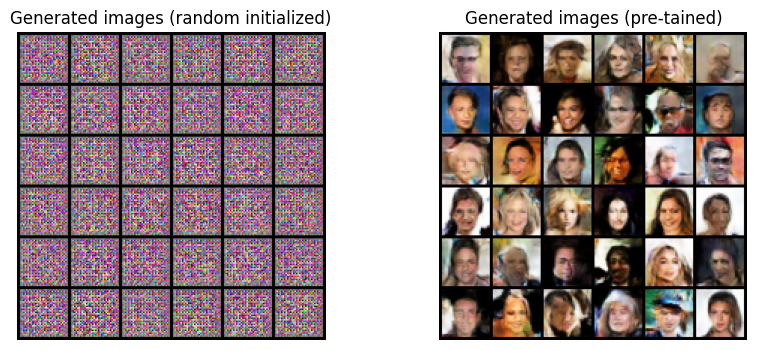

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# Create the instances of Generator and Discriminator
model_G = Generator().to(device)
model_D = Discriminator().to(device)

# Create a set of fixed noise vectors for visualization
fixed_noise = torch.randn((36, 100, 1, 1), device=device)

# Generate images with the random initialized Generator and display them
generated_images = model_G(fixed_noise)
generated_images = utils.make_grid(generated_images.detach().cpu(), padding=2, normalize=True, nrow=6)

ax[0].axis('off')
ax[0].set_title('Generated images (random initialized)')
ax[0].imshow(np.transpose(generated_images, (1, 2, 0)))

# Load the pre-trained weights for the Generator and Discriminator
load_pretrained_weights(model_G, model_D, device)

# Generate images with the pre-trained Generator and display them
generated_images_pretrained = model_G(fixed_noise)
generated_images_pretrained = utils.make_grid(generated_images_pretrained.detach().cpu(), padding=2, normalize=True, nrow=6)

ax[1].axis('off')
ax[1].set_title('Generated images (pre-tained)')
ax[1].imshow(np.transpose(generated_images_pretrained, (1, 2, 0)))

If the pre-trained weights have been loaded correctly, you should see faces in the generated images on the right instead of random noise (as in the case of random initialization on the left).

## Part 3. Retrain the pre-trained GAN on a new dataset

### 3.1 Preparing the dataset and dataloader

First, let's define some hyperparameters for the data preprocessing and training.

**Please do NOT modify any of the code in this section 3.1!**

In [ ]:
# Image size
image_size = 32

# Batch size for training
batch_size = 128
num_workers = 1

# Learning rate for optimizers
lr = 0.0002

# Number of training epochs
num_epochs = 30

Then, let's create the dataset and dataloader to load the AnimeFace dataset for training.

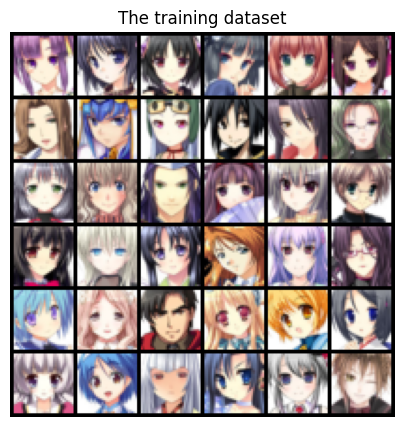

In [ ]:
# We can use the ImageFolder class due to the structure of the AnimeFace dataset
# Create the dataset
dataset = torchvision.datasets.ImageFolder(
    root='./data_hw4',
    transform=transforms.Compose([
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])
)

# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(5, 5))
plt.axis('off')
plt.title('The training dataset')
plt.imshow(np.transpose(utils.make_grid(real_batch[0].to(device)[:36], padding=2, normalize=True, nrow=6).cpu(),(1,2,0)))

Finally, we integrate all the model definition and initialization steps into one function `init_model_and_optimizer()`.

We choose binary cross entropy ([`nn.BCELoss()`](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html)) as the loss function because we are dealing with a binary classification problem.

In [ ]:
def init_model_and_optimizer():

    # Create the instances of Generator and Discriminator
    model_G = Generator().to(device)
    model_D = Discriminator().to(device)

    # Load the pre-trained weights for model_G and model_D
    load_pretrained_weights(model_G, model_D, device)

    # Setup Adam optimizers for both model_G and model_D
    optimizer_G = torch.optim.Adam(model_G.parameters(), lr=lr, betas=(0.5, 0.999))
    optimizer_D = torch.optim.Adam(model_D.parameters(), lr=lr, betas=(0.5, 0.999))

    # Initialize the loss function for training
    BCE_loss = nn.BCELoss()

    return model_G, model_D, optimizer_G, optimizer_D, BCE_loss

In [ ]:
model_G, model_D, optimizer_G, optimizer_D, BCE_loss = init_model_and_optimizer()

<ipython-input-48-36e1dab7d926>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights_G = torch.load(weights_G_path, map_location=device)
<ipython-input-48-36e1dab7d926>:

### 3.2 Implement the training step for the discriminator (<span style="color:green">2 points</span>)

The training data for the discriminator comes from two sources:
- Real images, such as real pictures of faces: The discriminator uses these instances as positive examples during training.
- Fake images generated by the generator: The discriminator uses these instances as negative examples during training.

The training step for the discriminator is shown in the figure below. During the training step:
- The discriminator classifies both **real images and fake images** from the generator.
- The discriminator loss penalizes the discriminator for misclassifying a real instance as fake or a fake instance as real.
- The discriminator updates its weights through backpropagation from the discriminator loss through the discriminator network.

<img src="https://developers.google.com/static/machine-learning/gan/images/gan_diagram_discriminator.svg" width="650" style="float: left;">

Now, fill in the missing parts in the code cell below to implement the training step for the discriminator.

In [ ]:
def training_step_D(
    real_images,
    model_G: nn.Module,
    model_D: nn.Module,
    optimizer_D: torch.optim.Optimizer,
    BCE_loss: nn.BCELoss,
    is_debug=False,
):
    """Method of the training step for Discriminator.

    Args:
        real_images: a batch of real image data from the training dataset
        model_G: the generator model
        model_D: the discriminator model
        optimizer_D: optimizer of the Discriminator
        BCE_loss: binary cross entropy loss function for loss computation

    Returns:
        loss_D: the discriminator loss

    """

    # Reset the gradients of all parameters in discriminator
    model_D.zero_grad()

    batch_size = real_images.shape[0]

    # Prepare the real images and their labels
    real_images = real_images.to(device)
    real_labels = torch.ones((batch_size,), device=device)

    # Prepare the fake images and their labels
    noise = torch.randn((batch_size, 100, 1, 1), device=device)
    fake_images = model_G(noise)
    fake_labels = torch.zeros((batch_size,), device=device)

    # Calculate losses for real and fake images
    real_outputs = model_D(real_images)
    loss_D_real = BCE_loss(real_outputs, real_labels)

    fake_outputs = model_D(fake_images)
    loss_D_fake = BCE_loss(fake_outputs, fake_labels)

    # Total discriminator loss
    loss_D = loss_D_real + loss_D_fake

    # Compute gradients
    loss_D.backward()

    # Update the parameters of `model_D`
    optimizer_D.step()

    if is_debug:
        print('Shape of real outputs:\n', real_outputs.shape, '\n')
        print('Shape and samples of real labels:\n', real_labels.shape, ' ', real_labels[:5], '\n')

        print('Shape of fake outputs:\n', fake_outputs.shape, '\n')
        print('Shape and samples of fake labels:\n', fake_labels.shape, ' ', fake_labels[:5], '\n')

    return loss_D

Check whether your implementation matches the reference outputs.

In [ ]:
torch.manual_seed(0)

batch_data = torch.randn((batch_size, 3, 32, 32), device=device)
model_G, model_D, optimizer_G, optimizer_D, BCE_loss = init_model_and_optimizer()

loss_D = training_step_D(batch_data, model_G, model_D, optimizer_D, BCE_loss, is_debug=True)
print('Discriminator loss:\n', loss_D)

<ipython-input-48-36e1dab7d926>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights_G = torch.load(weights_G_path, map_location=device)
<ipython-input-48-36e1dab7d926>:

Shape of real outputs:
 torch.Size([128]) 

Shape and samples of real labels:
 torch.Size([128])   tensor([1., 1., 1., 1., 1.]) 

Shape of fake outputs:
 torch.Size([128]) 

Shape and samples of fake labels:
 torch.Size([128])   tensor([0., 0., 0., 0., 0.]) 

Discriminator loss:
 tensor(11.3854, grad_fn=<AddBackward0>)


**<span style="color:green">Reference outputs:</span>** <br>
Shape of real outputs:<br>
 torch.Size([128]) <br>
<br>
Shape and samples of real labels:<br>
 torch.Size([128])&emsp;tensor([1., 1., 1., 1., 1.]) <br>
<br>
Shape of fake outputs:<br>
 torch.Size([128]) <br>
<br>
Shape and samples of fake labels:<br>
 torch.Size([128])&emsp;tensor([0., 0., 0., 0., 0.]) <br>
<br>
Discriminator loss:<br>
 tensor(11.3854, grad_fn=\<AddBackward0>)<br><br>
(If you are using GPU, you may get slightly different results for the discriminator loss, but this is okay)

### 3.3 Implement the training step for the generator (<span style="color:green">1.5 points</span>)

The training process for the generator requires tighter integration between the generator and the discriminator compared with the training step for the discriminator. The portion of the GAN that trains the generator includes:
- Random noise as input
- The generator network for transforming the random input into a data instance
- The discriminator network for classifying the generated data and its output
- Generator loss for penalizing the generator for failing to fool the discriminator

To train a neural net, we typically alter the model weights to reduce the error (loss). In our GAN, however, the generator is not directly connected to the loss that we're trying to affect. The generator feeds into the discriminator net, and the discriminator produces the output we're trying to affect. This training step is shown in the figure below.

**The generator loss penalizes the generator for producing an image that the discriminator network classifies as fake. In other words, we wish the generated images could be classified as real by the discriminator in this training step.**

<img src="https://developers.google.com/static/machine-learning/gan/images/gan_diagram_generator.svg" width="650" style="float: left;">

Now, fill in the missing parts in the code cell below to implement the training step for the generator.

In [ ]:
def training_step_G(
    model_G: nn.Module,
    model_D: nn.Module,
    optimizer_G: torch.optim.Optimizer,
    BCE_loss: nn.BCELoss,
    is_debug=False,
):
    """Method of the training step for Generator.

    Args:
        model_G: the generator model
        model_D: the discriminator model
        optimizer_G: optimizer for the generator
        BCE_loss: binary cross entropy loss function for loss computation

    Returns:
        loss_G: the generator loss

    """

    # Reset the gradients of all parameters in `model_G`
    model_G.zero_grad()

    # Generate fake images from `model_G` with random noises
    noise = torch.randn((batch_size, 100, 1, 1), device=device)
    fake_images = model_G(noise)

    # Prepare labels for fake_images
    labels = torch.ones((batch_size,), device=device)

    # Call `model_D()` and `BCE_loss` to calculate the loss of Generator
    outputs = model_D(fake_images)
    loss_G = BCE_loss(outputs, labels)

    # Compute the gradients
    loss_G.backward()

    # Update the parameters of `model_G`
    optimizer_G.step()

    if is_debug:
        print('Shape of outputs:\n', outputs.shape, '\n')
        print('Shape of labels:\n', labels.shape, '\n')

    return loss_G

Check whether your implementation matches the reference outputs.

In [ ]:
torch.manual_seed(0)

model_G, model_D, optimizer_G, optimizer_D, BCE_loss = init_model_and_optimizer()

loss_G = training_step_G(model_G, model_D, optimizer_G, BCE_loss, is_debug=True)

<ipython-input-48-36e1dab7d926>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights_G = torch.load(weights_G_path, map_location=device)
<ipython-input-48-36e1dab7d926>:

Shape of outputs:
 torch.Size([128]) 

Shape of labels:
 torch.Size([128]) 



**<span style="color:green">Reference outputs:</span>** <br>
Shape of outputs:<br>
 torch.Size([128]) <br>
<br>
Shape of labels:<br>
 torch.Size([128]) <br>

### Question: Why the real images are not used for training the generator? (<span style="color:green">0.5 point</span>)

**Your answer here: (TODO)**
The generator in a GAN learns to create realistic pictures by competing with the discriminator. It does not directly access real pictures, but instead learns indirectly via the discriminator's feedback. This avoids mode collapse and encourages the generator to investigate a broader variety of picture possibilities.

### 3.4 Train and evaluate your GAN  (<span style="color:green">1 point</span>)

Finally, fill in the missing parts in the code cell below to train your GAN.

Please note that here the additional GPU acceleration (mentioned at the beginning of this notebook) comes in handy as the training of the GAN model on CPU takes some time (see the training times for epochs in the provided reference times).

In [ ]:
# Create the model, optimizer, and loss functions for training
model_G, model_D, optimizer_G, optimizer_D, BCE_loss = init_model_and_optimizer()

# Lists and variables to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

torch.random.seed()
start_time = time.time()

# Training Loop
print("Starting the training loop...")

for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, (real_images, _) in enumerate(dataloader, 0):

        # Call the `training_step_D()` and `training_step_G()` and collect the loss values `loss_D` and `loss_G`
        loss_D = training_step_D(real_images, model_G, model_D, optimizer_D, BCE_loss)
        loss_G = training_step_G(model_G, model_D, optimizer_G, BCE_loss)

        # Output training stats
        if i % 50 == 0:
            print('[Epoch][Iter][{}/{}][{}/{}] Loss_D: {:.4f}, Loss_G: {:.4f}, Time: {:.2f} s'.format(
                epoch, num_epochs, i, len(dataloader), loss_D.item(), loss_G.item(), time.time() - start_time))
            start_time = time.time()

        # Save losses for plotting later
        G_losses.append(loss_G.item())
        D_losses.append(loss_D.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 50 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = model_G(fixed_noise).detach().cpu()
            img_list.append(utils.make_grid(fake, padding=2, normalize=True, nrow=6))
        iters += 1

print("Training finished!")

Starting the training loop...


<ipython-input-48-36e1dab7d926>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights_G = torch.load(weights_G_path, map_location=device)
<ipython-input-48-36e1dab7d926>:

[Epoch][Iter][0/30][0/16] Loss_D: 1.9668, Loss_G: 1.1271, Time: 1.54 s
[Epoch][Iter][1/30][0/16] Loss_D: 0.0612, Loss_G: 4.1993, Time: 12.04 s
[Epoch][Iter][2/30][0/16] Loss_D: 0.0871, Loss_G: 4.6465, Time: 11.94 s
[Epoch][Iter][3/30][0/16] Loss_D: 0.2832, Loss_G: 7.5016, Time: 12.26 s
[Epoch][Iter][4/30][0/16] Loss_D: 0.2119, Loss_G: 3.8675, Time: 12.22 s
[Epoch][Iter][5/30][0/16] Loss_D: 0.1960, Loss_G: 3.6779, Time: 12.31 s
[Epoch][Iter][6/30][0/16] Loss_D: 0.2818, Loss_G: 2.8579, Time: 12.31 s
[Epoch][Iter][7/30][0/16] Loss_D: 0.3591, Loss_G: 2.6502, Time: 12.47 s
[Epoch][Iter][8/30][0/16] Loss_D: 0.3579, Loss_G: 3.1178, Time: 12.41 s
[Epoch][Iter][9/30][0/16] Loss_D: 0.6084, Loss_G: 3.1474, Time: 12.43 s
[Epoch][Iter][10/30][0/16] Loss_D: 0.3665, Loss_G: 3.2097, Time: 12.28 s
[Epoch][Iter][11/30][0/16] Loss_D: 0.3316, Loss_G: 2.7424, Time: 12.33 s
[Epoch][Iter][12/30][0/16] Loss_D: 0.5786, Loss_G: 2.2397, Time: 12.14 s
[Epoch][Iter][13/30][0/16] Loss_D: 0.4319, Loss_G: 3.1980, Tim

Let's plot the generator and discriminator losses during training our GAN.

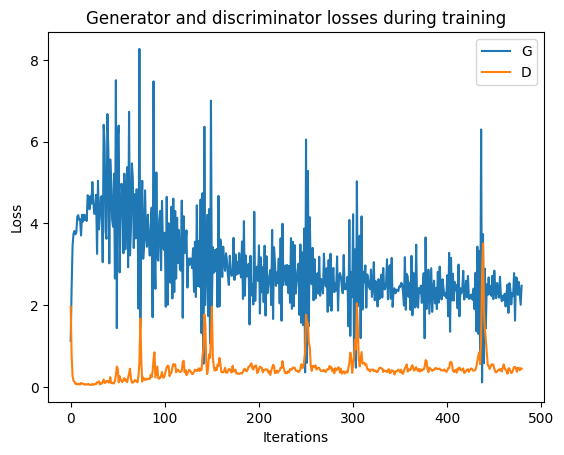

In [ ]:
plt.figure()
plt.title("Generator and discriminator losses during training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

Let's inspect how the generated images look like after the training of our GAN has finished.

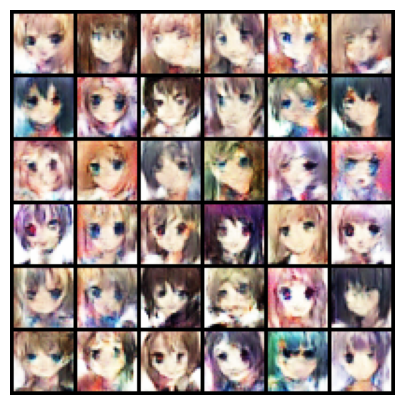

In [ ]:
fig = plt.figure(figsize=(5, 5))
plt.axis("off")

ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]

**Hints: If you cannot get any expected outputs similar to the images in the AnimeFace dataset, try to debug your code of `training_step_G()` and `training_step_D()` again.**

We can also visualize how the quality of the generated images changes during training.

In [ ]:
ani = animation.ArtistAnimation(fig, ims, interval=300, repeat_delay=1000, blit=True)
HTML(ani.to_jshtml())